In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy import stats
from copy import deepcopy
from datetime import datetime
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 输入参数

In [2]:
#感兴趣的指数，例如上证综合指数
index = ['M0020188']

#起止时间
t0 = '2004-06-01'
t1 = '2020-08-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'W'

#初始周期跨度，第一次现趋势修正跨度，第二次现趋势修正跨度
itv = 8
itv2 = 4
itv3 = 4
#分位数
m = 0.5

#新趋势出现判断
n = 0.628

# 从WIND读取数据

空值沿用前值，选用收盘数据。

In [21]:
int_list = ['M0020188','S0105896','M1004271','M1004263']
tr = w.wsd(int_list, 'close', t0, t1, Period = prd, Fill = 'Previous')
tr.Times

[datetime.date(2004, 6, 4),
 datetime.date(2004, 6, 11),
 datetime.date(2004, 6, 18),
 datetime.date(2004, 6, 25),
 datetime.date(2004, 7, 2),
 datetime.date(2004, 7, 9),
 datetime.date(2004, 7, 16),
 datetime.date(2004, 7, 23),
 datetime.date(2004, 7, 30),
 datetime.date(2004, 8, 6),
 datetime.date(2004, 8, 13),
 datetime.date(2004, 8, 20),
 datetime.date(2004, 8, 27),
 datetime.date(2004, 9, 3),
 datetime.date(2004, 9, 10),
 datetime.date(2004, 9, 17),
 datetime.date(2004, 9, 24),
 datetime.date(2004, 9, 30),
 datetime.date(2004, 10, 8),
 datetime.date(2004, 10, 15),
 datetime.date(2004, 10, 22),
 datetime.date(2004, 10, 29),
 datetime.date(2004, 11, 5),
 datetime.date(2004, 11, 12),
 datetime.date(2004, 11, 19),
 datetime.date(2004, 11, 26),
 datetime.date(2004, 12, 3),
 datetime.date(2004, 12, 10),
 datetime.date(2004, 12, 17),
 datetime.date(2004, 12, 24),
 datetime.date(2004, 12, 31),
 datetime.date(2005, 1, 7),
 datetime.date(2005, 1, 14),
 datetime.date(2005, 1, 21),
 datetime.

In [3]:
df = []
date = []
for i in index:
    df.append(w.wsd(i, 'close', t0, t1, Period = prd, Fill = 'Previous').Data[0])
    date.append(w.wsd(i, 'close', t0, t1, Period = prd, Fill = 'Previous').Times)

# 数据可视化

1为是否同一张图内观察所有指数，0为否。

<Figure size 1080x576 with 0 Axes>

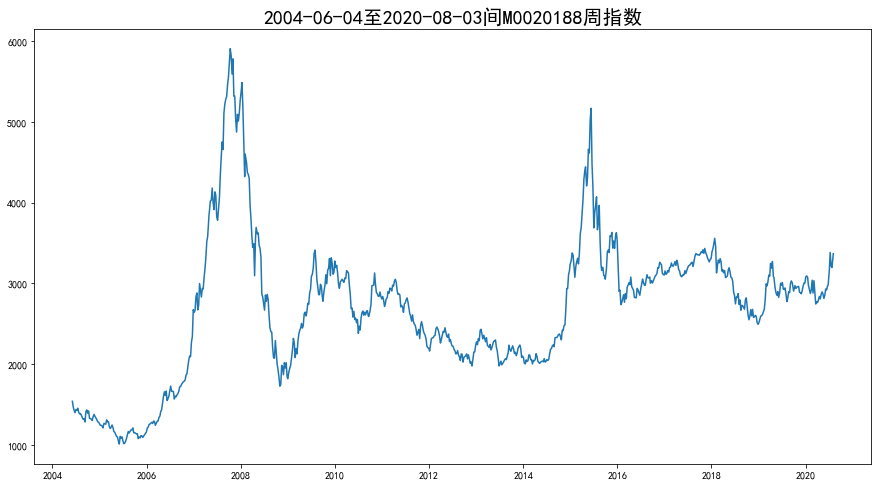

In [4]:
_all = 0
p = []    
title = ''
plt.figure(figsize=(15,8))
plt.rcParams['font.family']=['SimHei']

for i, j in enumerate(index):
    if _all:
        p += plt.plot(date[i], df[i])
        title += j + '， '
        if i == len(index) - 1:
            plt.legend(index,loc = 2)
            plt.title(str(date[0][0])+'至'+str(date[0][-1])+'间'+title+dic[prd]+'指数')
    else:
        plt.figure(figsize=(15,8))
        plt.plot(date[i], df[i])
        plt.title(str(date[i][0])+'至'+str(date[i][-1])+'间'+j+dic[prd]+'指数',
                 fontproperties='SimHei', size = 20)
        plt.show()

# 建立模型

## 指数单独分析

根据数据生成新变量

In [5]:
df = df[0]
date = date[0]

In [6]:
l = len(df)
#在周期跨度itv内：
trend = l * [0]         #周期内趋势
sig = l * [0]           #反转
newtrend = l * [0]      #现趋势  

for i in range(itv, l):
    #提取周期内数据
    df_i = df[i-itv:i+1]
    
    #得出极值与坐标
    _max = max(df_i)
    _min = min(df_i)
    id_max = df_i.index(_max)
    id_min = df_i.index(_min)
    
    #根据极值与坐标得出该周期内的趋势
    trend[i] = -(-1) ** int(id_max > id_min)
    
    #与前个周期趋势对比得出是否反转
    sig[i] = int(trend[i] != trend[i-1]) * -(-1) ** int(trend[i] > trend[i-1])
    
    #根据新趋势出现判断的参数判断未来趋势，n = 0.628
    if trend[i] == -1:
        newtrend[i] = -(-1) ** (((df[i]-_min)/(_max-_min)) > n)
    else:
        newtrend[i] = (-1) ** (((_max-df[i])/(_max-_min)) > n)



Text(0.5, 1.0, '2004-06-04至2020-08-03间周指数每周期内趋势')

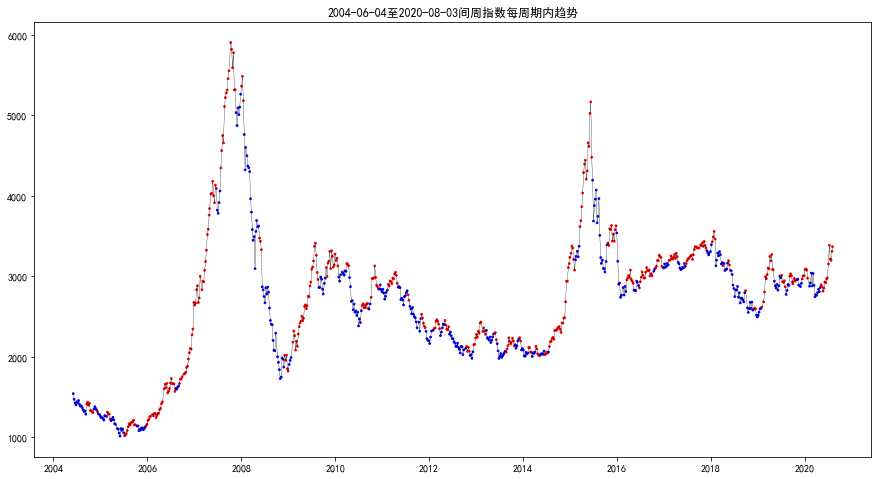

In [7]:
col = ['r', 'b']
plt.figure(figsize=(15,8))
plt.plot(date, df, c='black', linewidth = .3)
plt.scatter(date, df, c = [col[0] if i == 1 else col[1] for i in trend], s = 3)
plt.title(str(date[0])+'至'+str(date[-1])+'间'+title+dic[prd]+'指数每周期内趋势')

Text(0.5, 1.0, '2004-06-04至2020-08-03间周指数每周期内反转状况')

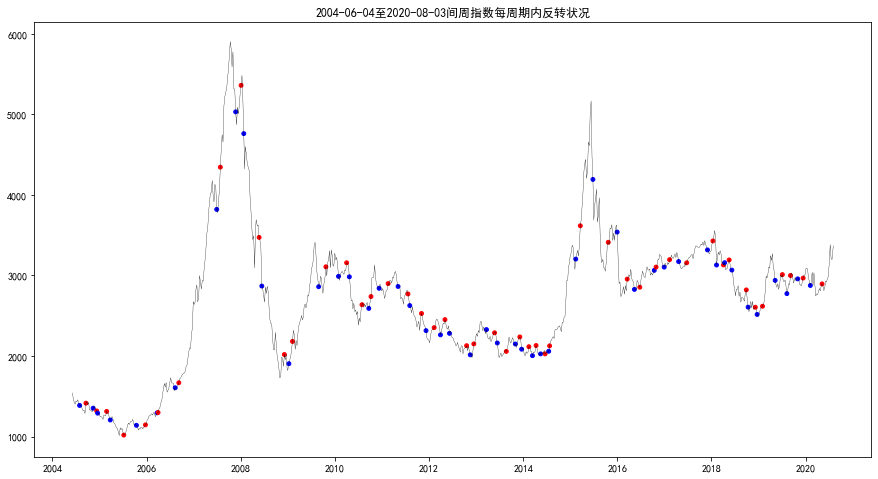

In [8]:
col = ['r', 'b']
plt.figure(figsize=(15,8))
plt.plot(date,df,c='black', linewidth = .3)
plt.scatter(date, df, c = [col[0] if i == 1 else col[1] for i in sig], s = [15 if i != 0 else 0 for i in sig])
plt.title(str(date[0])+'至'+str(date[-1])+'间'+title+dic[prd]+'指数每周期内反转状况')

Text(0.5, 1.0, '2004-06-04至2020-08-03间周指数每周期内现趋势')

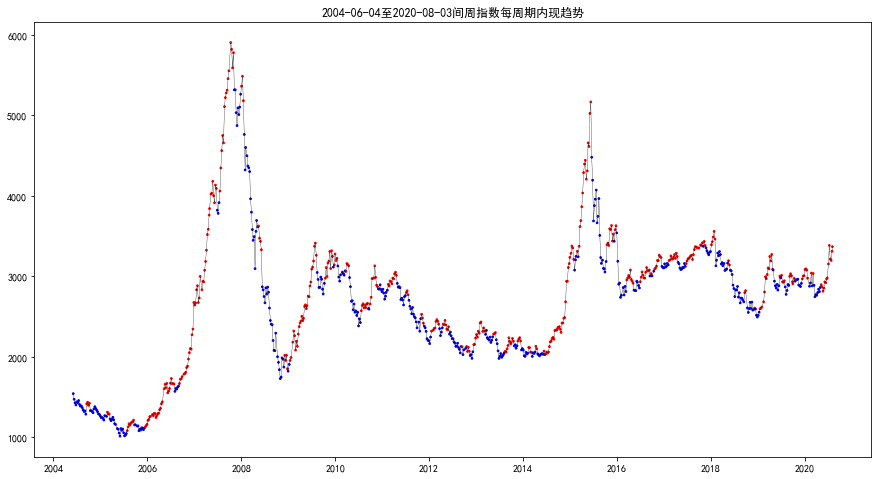

In [9]:
col = ['r', 'b']
plt.figure(figsize=(15,8))
plt.plot(date,df,c='black', linewidth = .3)
plt.scatter(date, df, c = [col[0] if i == 1 else col[1] for i in newtrend], s = 3)
plt.title(str(date[0])+'至'+str(date[-1])+'间'+title+dic[prd]+'指数每周期内现趋势')

In [10]:
#现趋势涨幅第一次修正

trend_cor = deepcopy(newtrend)  

for i in range(100, l):
    #第一所选区间，与极值
    df_i = df[i-itv2+1:i+1]
    _min = min(df_i)
    _max = max(df_i)
    
    #周期末指数与极值的比例
    now = df[i]/[_min,_max][newtrend[i] == -1]-1
    s = []
    
    for j in range(itv2,i):
        #第一所选区间100天以内的第二所选区间，与极值
        df_j = df[j-itv2:j]
        j_min = min(df_j)
        j_max = max(df_j)
        
        #第二所选区间的现趋势
        t = newtrend[j-itv2:j]
        
        #若所选现趋势区间内现趋势恒定，则在表中添加第二所选区间极值函数，最多添加100-itv2次
        if abs(sum(t)) == itv2:
            s.append([j_min,j_max][newtrend[i] == 1]/[j_min,j_max][newtrend[i] == -1]-1)
    
    #若周期末指数与极值的比例，超过或低于，100天内现趋势恒定的极值函数，一定分位数水平，则当前现趋势涨幅修正变为上个周期的涨幅修正      
    if newtrend[i] == 1 and now < np.quantile(s, m):
        trend_cor[i] = trend_cor[i-1] 
    elif newtrend[i] == -1 and now > np.quantile(s, 1-m):
        trend_cor[i] = trend_cor[i-1] 

cor1 = deepcopy(trend_cor)

第一次现趋势涨幅修正占比

In [11]:
round(sum([trend_cor[i] != newtrend[i] for i in range(len(newtrend))])/len(newtrend),3)

0.175

Text(0.5, 1.0, '2004-06-04至2020-08-03间周指数每周期内现趋势第一次修正部分')

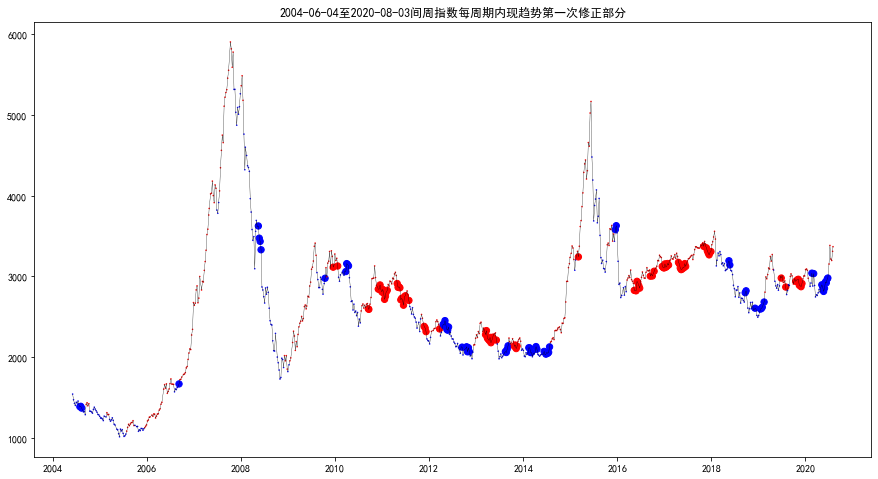

In [18]:
col = ['r', 'b']
plt.figure(figsize=(15,8))
plt.plot(date,df,c='black', linewidth = .3)
plt.scatter(date, df, c = [col[0] if i == 1 else col[1] for i in trend_cor],
            s = [40 if trend_cor[i] != newtrend[i] else .3 for i in range(l)])
plt.title(str(date[0])+'至'+str(date[-1])+'间'+title+dic[prd]+'指数每周期内现趋势第一次修正部分')

In [13]:
#现趋势涨幅第二次修正，itv3 = 4

pos = 1
while pos < l-1:
    step = 1
    if abs(sum(trend_cor[pos-1:pos+2])) == 3:  #[1,1,1]，移动到第四周期
        pos += 2
        
    elif trend_cor[pos] * trend_cor[pos-1] + trend_cor[pos] * trend_cor[pos+1] == -2: #[1,-1,1]，将中间的现趋势修正，移动到第四周期
        trend_cor[pos] = trend_cor[pos-1]
        pos += 2
        
    elif trend_cor[pos] * trend_cor[pos-1] + trend_cor[pos] * trend_cor[pos+1] == 0:  #[1,1,-1]，移动到第三个周期
        pos += 1
        
    else:  #[1,-1,-1]，在相同的现趋势达到3（itv3-1）个前，尽可能多的修正中间的现趋势
        if abs(sum(trend_cor[pos-1:pos+itv3])) == itv3-1:  #[1, -1, -1, -1, -1]，连续（itv3-1）个周期不变，移动到第（itv3+2）周期
            pos += itv3
            
        else: #[1, -1, -1, 1] 或 [1, -1, -1, -1, 1]，将中间2或3个周期的现趋势修正，并移动到第五或第六周期处
            while step < itv3 and trend_cor[pos+step] != trend_cor[pos-1]:
                trend_cor[pos+step-1] = trend_cor[pos-1]
                step += 1
            pos += step

#trend_cor为修正后的现趋势

第二次现趋势涨幅修正占比

In [15]:
round(sum([trend_cor[i] != cor1[i] for i in range(len(trend_cor))])/len(trend_cor),3)

0.007

Text(0.5, 1.0, '2004-06-04至2020-08-03间周指数每周期内现趋势第二次修正部分')

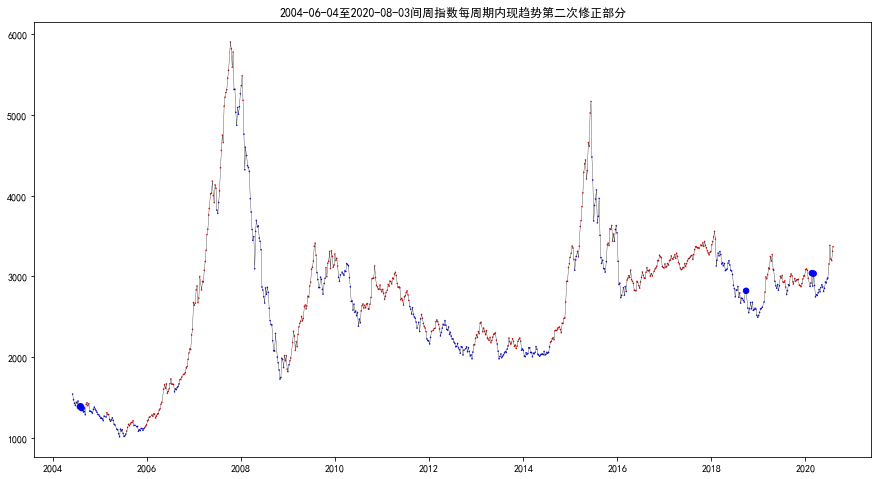

In [17]:
col = ['r', 'b']
plt.figure(figsize=(15,8))
plt.plot(date,df,c='black', linewidth = .3)
plt.scatter(date, df, c = [col[0] if i == 1 else col[1] for i in trend_cor],
            s = [30 if trend_cor[i] != cor1[i] else .3 for i in range(l)])
plt.title(str(date[0])+'至'+str(date[-1])+'间'+title+dic[prd]+'指数每周期内现趋势第二次修正部分')

## 所选指数综合分析